# **Similarity between two structures**

## **Install conda and rdkid**

In [1]:
# Install conda and rdkit
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-04-08 19:21:49--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   141MB/s    in 0.6s    

2021-04-08 19:21:50 (141 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b64

In [2]:
import pandas as pd
df = pd.read_csv('CHEMBL1957_2classes_data.csv')
df.head(5)

,molecule_chembl_id,canonical_smiles,pIC50,bioactivity_class
0,CHEMBL3823268,COc1cc(P(C)(C)=O)ccc1Nc1ncc(Cl)c(Nc2ccccc2C(N)...,9.958607,active
1,CHEMBL3652826,COc1cc(OCCN2CCCC2)ccc1Nc1ncc2c(n1)-c1c(nn(C)c1...,9.744727,active
2,CHEMBL3656563,COc1cc(N2CCN(C)CC2)ccc1Nc1ncc2c(n1)-c1c(nn(C)c...,9.721246,active
3,CHEMBL3656576,COc1cc(N2CCN(C)CC2)ccc1Nc1ncc2c(n1)-c1c(nn(C)c...,9.721246,active
4,CHEMBL3656637,COCCn1ccc(Nc2ncc3c(n2)-c2c(nn(C)c2-c2ccc(Cl)cc...,9.698970,active


In [3]:
print(
    ' active',df['bioactivity_class'][df['bioactivity_class']=="active"].count(),'\n',
    'inactive',df['bioactivity_class'][df['bioactivity_class']=="inactive"].count(),'\n'
)

 active 447 
 inactive 442 



In [4]:
acive_canonical_smiles = df['canonical_smiles'][df['bioactivity_class']=="active"]
#acive_canonical_smiles.count()
#len(acive_canonical_smiles)
acive_canonical_smiles.head(3)

0    COc1cc(P(C)(C)=O)ccc1Nc1ncc(Cl)c(Nc2ccccc2C(N)...
1    COc1cc(OCCN2CCCC2)ccc1Nc1ncc2c(n1)-c1c(nn(C)c1...
2    COc1cc(N2CCN(C)CC2)ccc1Nc1ncc2c(n1)-c1c(nn(C)c...
Name: canonical_smiles, dtype: object

In [5]:
inacive_canonical_smiles = df['canonical_smiles'][df['bioactivity_class']=="inactive"].reset_index().drop(columns='index')
inacive_canonical_smiles = inacive_canonical_smiles['canonical_smiles']

In [6]:
inacive_canonical_smiles.count()
inacive_canonical_smiles.head(3)

0    O=C(Nc1cccc(-c2c[nH]c3ncc(-c4ccccc4)cc23)c1)Nc...
1     CCCNC(=O)c1ccc(Nc2nc(NCC(F)(F)F)c3cc[nH]c3n2)cc1
2            CC(=O)Oc1ccc(CNc2ccc3c(c2)OCO3)cc1OC(C)=O
Name: canonical_smiles, dtype: object

## **Calculate SMILE Similarity**

In [7]:
from rdkit import Chem,DataStructs

row_size = len(acive_canonical_smiles) #active
column_size = len(inacive_canonical_smiles) #inactive

table= [ [ 0 for i in range(column_size) ] for j in range(row_size) ]
#np.shape(table)
#pd.DataFrame(table)

for row in range(0,row_size):
  for col in range(0,column_size):
    act_comp = acive_canonical_smiles[row]
    inact_comp = inacive_canonical_smiles[col]

    act_mol = Chem.MolFromSmiles(str(act_comp))
    inact_mol = Chem.MolFromSmiles(str(inact_comp))

    # the default fingerprint is path-based:
    act_fp = Chem.RDKFingerprint(act_mol)
    inact_fp = Chem.RDKFingerprint(inact_mol)

    table[row][col]= DataStructs.TanimotoSimilarity(act_fp,inact_fp)

In [8]:
pd.DataFrame(table)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441
0,0.309715,0.431512,0.270091,0.410834,0.369055,0.395031,0.373011,0.372663,0.189003,0.400000,0.356436,0.401564,0.355599,0.353936,0.372698,0.374441,0.343243,0.324403,0.416606,0.239243,0.409375,0.404667,0.401858,0.396057,0.376440,0.354965,0.399876,0.428761,0.325067,0.207531,0.362272,0.347797,0.239226,0.387405,0.302632,0.416918,0.369662,0.354098,0.410007,0.370395,...,0.359656,0.340941,0.321814,0.208048,0.346897,0.394675,0.330269,0.360811,0.221453,0.362893,0.370551,0.333983,0.348408,0.216899,0.324219,0.335227,0.362396,0.325722,0.329122,0.227580,0.393802,0.289799,0.371004,0.305671,0.317294,0.322420,0.349869,0.251375,0.433468,0.286754,0.432209,0.425620,0.327246,0.223806,0.303623,0.353369,0.297436,0.296864,0.318448,0.427910
1,0.370760,0.389282,0.280098,0.594775,0.506392,0.521763,0.496960,0.495536,0.216981,0.565098,0.402841,0.496441,0.474128,0.478652,0.504714,0.491170,0.431229,0.372549,0.498199,0.229012,0.578178,0.491582,0.534896,0.570419,0.503898,0.353883,0.531267,0.572009,0.427442,0.246250,0.484524,0.453349,0.226533,0.506895,0.369935,0.563715,0.507538,0.461453,0.435550,0.468227,...,0.356635,0.427752,0.417458,0.217877,0.434135,0.393070,0.446128,0.458215,0.219255,0.494228,0.464764,0.455562,0.474033,0.213707,0.446558,0.413372,0.373099,0.424140,0.435811,0.233518,0.496411,0.319857,0.416322,0.398509,0.443787,0.423759,0.459866,0.319385,0.533714,0.388623,0.619075,0.543581,0.394582,0.236777,0.376684,0.453326,0.365882,0.370000,0.382716,0.571926
2,0.376078,0.397562,0.282622,0.613046,0.525996,0.532579,0.504913,0.508568,0.234599,0.569579,0.432309,0.532777,0.484158,0.490272,0.516749,0.495922,0.438577,0.399194,0.537764,0.225225,0.593192,0.498893,0.553988,0.578184,0.517660,0.362734,0.534547,0.599536,0.451014,0.265015,0.492778,0.455568,0.231005,0.510592,0.372911,0.582483,0.516271,0.481379,0.438982,0.470943,...,0.357516,0.434463,0.413813,0.215840,0.440745,0.388338,0.469502,0.464426,0.214976,0.517828,0.455165,0.481295,0.496145,0.209570,0.471508,0.413911,0.384749,0.446880,0.457656,0.230354,0.504362,0.322261,0.438493,0.417664,0.438728,0.419988,0.484697,0.314748,0.573402,0.384795,0.648352,0.574292,0.395497,0.244713,0.381912,0.457096,0.371313,0.374566,0.387060,0.601277
3,0.374344,0.392019,0.284926,0.605571,0.515303,0.527174,0.500827,0.505310,0.237611,0.562806,0.426437,0.536039,0.474804,0.480963,0.506910,0.492578,0.433708,0.395335,0.543050,0.224191,0.588169,0.492179,0.539467,0.570655,0.514509,0.359172,0.530844,0.602829,0.449515,0.267045,0.484323,0.448354,0.232355,0.506586,0.367930,0.569040,0.506385,0.478628,0.435597,0.467295,...,0.358702,0.428653,0.410106,0.215385,0.434188,0.390041,0.467422,0.457321,0.216000,0.513019,0.452039,0.478531,0.491101,0.210494,0.469457,0.410271,0.380702,0.445330,0.456250,0.231663,0.495332,0.320520,0.440191,0.416522,0.434503,0.416374,0.480315,0.314442,0.571678,0.383155,0.652378,0.578191,0.389959,0.243243,0.373837,0.454900,0.363902,0.367192,0.379813,0.604596
4,0.369485,0.368613,0.252378,0.563739,0.486286,0.493333,0.480912,0.472509,0.201316,0.536572,0.394799,0.433492,0.460465,0.458382,0.483761,0.467459,0.417736,0.366426,0.444041,0.213411,0.549110,0.490643,0.514270,0.541320,0.479452,0.370510,0.507238,0.518410,0.403132,0.230418,0.462695,0.439573,0.204294,0.473596,0.356098,0.538079,0.487371,0.428490,0.388558,0.448652,...,0.373426,0.412218,0.410526,0.211111,0.417160,0.400756,0.420841,0.437098,0.207818,0.464085,0.427893,0.429799,0.446580,0.198046,0.419725,0.400483,0.383807,0.399768,0.408540,0.216581,0.476163,0.313628,0.399021,0.375443,0.435345,0.402439,0.437572,0.321429,0.489300,0.381250,0.566027,0.489917,0.388445,0.227097,0.363139,0.432432,0.354345,0.356139,0.359394,0.518389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [9]:
import numpy as np

pd.DataFrame(table).to_csv("IGF1R_EDA_similarity_matrix.csv", index=None)

## **Heat Map of Similarity**

In [10]:
import pandas as pd

df2 = pd.read_csv('IGF1R_EDA_similarity_matrix.csv')
df2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441
0,0.309715,0.431512,0.270091,0.410834,0.369055,0.395031,0.373011,0.372663,0.189003,0.400000,0.356436,0.401564,0.355599,0.353936,0.372698,0.374441,0.343243,0.324403,0.416606,0.239243,0.409375,0.404667,0.401858,0.396057,0.376440,0.354965,0.399876,0.428761,0.325067,0.207531,0.362272,0.347797,0.239226,0.387405,0.302632,0.416918,0.369662,0.354098,0.410007,0.370395,...,0.359656,0.340941,0.321814,0.208048,0.346897,0.394675,0.330269,0.360811,0.221453,0.362893,0.370551,0.333983,0.348408,0.216899,0.324219,0.335227,0.362396,0.325722,0.329122,0.227580,0.393802,0.289799,0.371004,0.305671,0.317294,0.322420,0.349869,0.251375,0.433468,0.286754,0.432209,0.425620,0.327246,0.223806,0.303623,0.353369,0.297436,0.296864,0.318448,0.427910
1,0.370760,0.389282,0.280098,0.594775,0.506392,0.521763,0.496960,0.495536,0.216981,0.565098,0.402841,0.496441,0.474128,0.478652,0.504714,0.491170,0.431229,0.372549,0.498199,0.229012,0.578178,0.491582,0.534896,0.570419,0.503898,0.353883,0.531267,0.572009,0.427442,0.246250,0.484524,0.453349,0.226533,0.506895,0.369935,0.563715,0.507538,0.461453,0.435550,0.468227,...,0.356635,0.427752,0.417458,0.217877,0.434135,0.393070,0.446128,0.458215,0.219255,0.494228,0.464764,0.455562,0.474033,0.213707,0.446558,0.413372,0.373099,0.424140,0.435811,0.233518,0.496411,0.319857,0.416322,0.398509,0.443787,0.423759,0.459866,0.319385,0.533714,0.388623,0.619075,0.543581,0.394582,0.236777,0.376684,0.453326,0.365882,0.370000,0.382716,0.571926
2,0.376078,0.397562,0.282622,0.613046,0.525996,0.532579,0.504913,0.508568,0.234599,0.569579,0.432309,0.532777,0.484158,0.490272,0.516749,0.495922,0.438577,0.399194,0.537764,0.225225,0.593192,0.498893,0.553988,0.578184,0.517660,0.362734,0.534547,0.599536,0.451014,0.265015,0.492778,0.455568,0.231005,0.510592,0.372911,0.582483,0.516271,0.481379,0.438982,0.470943,...,0.357516,0.434463,0.413813,0.215840,0.440745,0.388338,0.469502,0.464426,0.214976,0.517828,0.455165,0.481295,0.496145,0.209570,0.471508,0.413911,0.384749,0.446880,0.457656,0.230354,0.504362,0.322261,0.438493,0.417664,0.438728,0.419988,0.484697,0.314748,0.573402,0.384795,0.648352,0.574292,0.395497,0.244713,0.381912,0.457096,0.371313,0.374566,0.387060,0.601277
3,0.374344,0.392019,0.284926,0.605571,0.515303,0.527174,0.500827,0.505310,0.237611,0.562806,0.426437,0.536039,0.474804,0.480963,0.506910,0.492578,0.433708,0.395335,0.543050,0.224191,0.588169,0.492179,0.539467,0.570655,0.514509,0.359172,0.530844,0.602829,0.449515,0.267045,0.484323,0.448354,0.232355,0.506586,0.367930,0.569040,0.506385,0.478628,0.435597,0.467295,...,0.358702,0.428653,0.410106,0.215385,0.434188,0.390041,0.467422,0.457321,0.216000,0.513019,0.452039,0.478531,0.491101,0.210494,0.469457,0.410271,0.380702,0.445330,0.456250,0.231663,0.495332,0.320520,0.440191,0.416522,0.434503,0.416374,0.480315,0.314442,0.571678,0.383155,0.652378,0.578191,0.389959,0.243243,0.373837,0.454900,0.363902,0.367192,0.379813,0.604596
4,0.369485,0.368613,0.252378,0.563739,0.486286,0.493333,0.480912,0.472509,0.201316,0.536572,0.394799,0.433492,0.460465,0.458382,0.483761,0.467459,0.417736,0.366426,0.444041,0.213411,0.549110,0.490643,0.514270,0.541320,0.479452,0.370510,0.507238,0.518410,0.403132,0.230418,0.462695,0.439573,0.204294,0.473596,0.356098,0.538079,0.487371,0.428490,0.388558,0.448652,...,0.373426,0.412218,0.410526,0.211111,0.417160,0.400756,0.420841,0.437098,0.207818,0.464085,0.427893,0.429799,0.446580,0.198046,0.419725,0.400483,0.383807,0.399768,0.408540,0.216581,0.476163,0.313628,0.399021,0.375443,0.435345,0.402439,0.437572,0.321429,0.489300,0.381250,0.566027,0.489917,0.388445,0.227097,0.363139,0.432432,0.354345,0.356139,0.359394,0.518389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

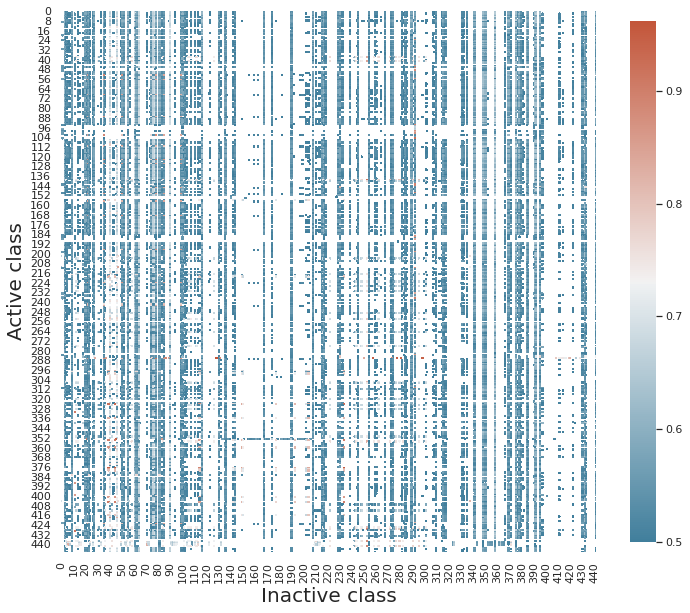

In [11]:
#from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.abs(df2) < 0.5

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df2, mask=mask, cmap=cmap, cbar_kws={"shrink":.8}, square=True) #, vmax=.3, center=0, square=True, linewidths=.5

plt.xlabel('Inactive class', fontsize=20)
plt.ylabel('Active class', fontsize=20)

#fig.suptitle('Correlation matrix of bioactivity classes', fontsize=15)

plt.savefig('IGF1R_EDA_heatmap_similarity.pdf')